In [8]:
import xarray as xr 
import numpy as np 
import numpy.ma as ma

import matplotlib.pyplot as plt
import pandas as pd
import os 
import copy
from scipy import signal

import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.ticker import MaxNLocator
#import collections
import matplotlib.ticker as mticker
from matplotlib import ticker
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import cartopy.crs as ccrs
import cartopy as cart
import cartopy.mpl.ticker as cticker
import cartopy.feature as cfeature
from matplotlib.colors import ListedColormap
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
from cartopy.util import add_cyclic_point
from matplotlib.colors import BoundaryNorm
import cmocean
import scipy as sp
import warnings
warnings.filterwarnings("ignore")
import os
import eofs.standard as Eof_st
from eofs.multivariate.standard import MultivariateEof
from eofs.xarray import Eof
from scipy.signal import butter, lfilter
from scipy.signal import convolve
import importlib
def reimport_module(module_name):
    """
    Reimports the specified Python module.
    
    Args:
    module_name (module): The module to be reimported, typically passed as a variable.
    
    Returns:
    module: The reloaded module.
    """
    try:
        # Reload the already imported module
        reloaded_module = importlib.reload(module_name)
        print(f"Module {module_name.__name__} reloaded successfully.")
        return reloaded_module
    except Exception as e:
        print(f"Failed to reload module: {e}")


In [24]:
###########################################################
####################### Template ##########################
###########################################################

Pats = ['NPO']
pattern = Pats[0]
season = 'DJF'

save_Fig_out = f'./{pattern}_{season}_panel.png'

### 1
dir_out = '/glade/derecho/scratch/wchapman/ADF/ERA5_data/ts/climo/'
DSpat_ERA5 = xr.open_dataset(f'{dir_out }/{Pats[0]}_bootstrapped_modes_{season}.nc')

if pattern=='PNA':
    condition = DSpat_ERA5[pattern].sel(lat=40, lon=190, method='nearest') > -200
    member_indices_to_remove = np.where(condition)[0]
    DSpat_ERA5 = DSpat_ERA5.drop_sel(member=member_indices_to_remove)

if pattern=='NAM':
    condition = DSpat_ERA5[pattern].sel(lat=40, lon=190, method='nearest') < 100
    member_indices_to_remove = np.where(condition)[0]
    DSpat_ERA5 = DSpat_ERA5.drop_sel(member=member_indices_to_remove)

if pattern=='NPO':
    condition = DSpat_ERA5[pattern].sel(lat=60,lon=180, method='nearest') > 200
    member_indices_to_remove = np.where(condition)[0]
    DSpat_ERA5 = DSpat_ERA5.drop_sel(member=member_indices_to_remove)



### 2
dir_out = '/glade/derecho/scratch/wchapman/ADF/f.e.FTORCHmjo_CNTRLmjo/ts/climo/'
DSpat_CNTRL = xr.open_dataset(f'{dir_out }/{Pats[0]}_bootstrapped_modes_{season}.nc')

if pattern=='PNA':
    condition = DSpat_CNTRL[pattern].sel(lat=40, lon=190, method='nearest') > -200
    member_indices_to_remove = np.where(condition)[0]
    DSpat_CNTRL = DSpat_CNTRL.drop_sel(member=member_indices_to_remove)

if pattern=='NAM':
    condition = DSpat_CNTRL[pattern].sel(lat=40, lon=190, method='nearest') < 100
    member_indices_to_remove = np.where(condition)[0]
    DSpat_CNTRL = DSpat_CNTRL.drop_sel(member=member_indices_to_remove)

if pattern=='NPO':
    condition = DSpat_CNTRL[pattern].sel(lat=60,lon=180, method='nearest') > 200
    member_indices_to_remove = np.where(condition)[0]
    DSpat_CNTRL = DSpat_CNTRL.drop_sel(member=member_indices_to_remove)

### 3 
dir_out = '/glade/derecho/scratch/wchapman/ADF/f.e.FTORCHmjo_MEANmjo/ts//climo/'
DSpat_MEAN = xr.open_dataset(f'{dir_out }/{Pats[0]}_bootstrapped_modes_{season}.nc')

if pattern=='PNA':
    condition = DSpat_MEAN[pattern].sel(lat=40, lon=190, method='nearest') > -200
    member_indices_to_remove = np.where(condition)[0]
    DSpat_MEAN = DSpat_MEAN.drop_sel(member=member_indices_to_remove)

if pattern=='NAM':
    condition = DSpat_MEAN[pattern].sel(lat=40, lon=190, method='nearest') < 100
    member_indices_to_remove = np.where(condition)[0]
    DSpat_MEAN = DSpat_MEAN.drop_sel(member=member_indices_to_remove)

if pattern=='NPO':
    condition = DSpat_MEAN[pattern].sel(lat=60,lon=180, method='nearest') > 200
    member_indices_to_remove = np.where(condition)[0]
    DSpat_MEAN = DSpat_MEAN.drop_sel(member=member_indices_to_remove)

### 4 
dir_out = '/glade/derecho/scratch/wchapman/ADF/f.e.FTORCHmjo_meanGPU_exp001/ts//climo/'
DSpat_FULL = xr.open_dataset(f'{dir_out }/{Pats[0]}_bootstrapped_modes_{season}.nc')

if pattern=='PNA':
    condition = DSpat_FULL[pattern].sel(lat=40, lon=190, method='nearest') > -200
    member_indices_to_remove = np.where(condition)[0]
    DSpat_FULL = DSpat_FULL.drop_sel(member=member_indices_to_remove)

if pattern=='NAM':
    condition = DSpat_FULL[pattern].sel(lat=40, lon=190, method='nearest') < 100
    member_indices_to_remove = np.where(condition)[0]
    DSpat_FULL = DSpat_FULL.drop_sel(member=member_indices_to_remove)

if pattern=='NPO':
    condition = DSpat_FULL[pattern].sel(lat=60,lon=180, method='nearest') > 200
    member_indices_to_remove = np.where(condition)[0]
    DSpat_FULL = DSpat_FULL.drop_sel(member=member_indices_to_remove)



## Plot as a panel

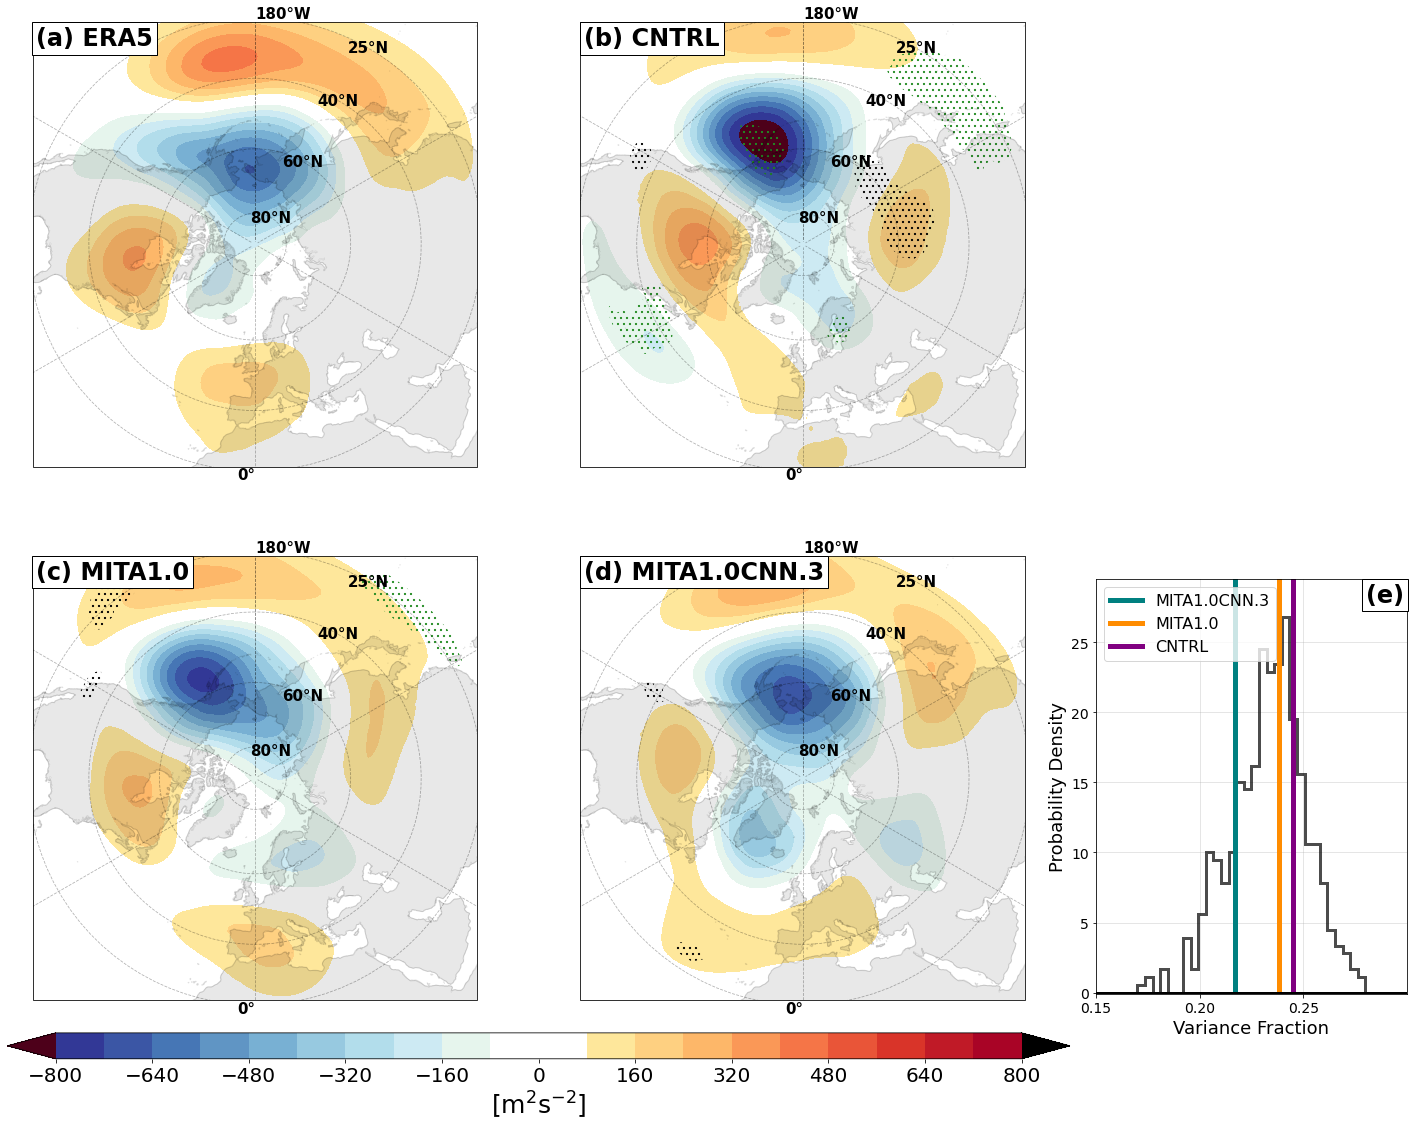

In [25]:
#### --- colormap
#### ++ init fig
fig = plt.figure(figsize=[18,18])
memno=0 #member to plot...
se = [-180, 180, 26, 90]
Max_Pascal = 800

#### -- init fig

cmap = plt.cm.RdYlBu_r
# extract all colors from the Reds map
cmaplist = [cmap(i) for i in range(cmap.N)]
# make the first color entry to be whhite
cmaplist[0] = cmap(1)
# make the last color entry to be most extreme--
cmaplist[cmap.N-1] = cmap(0.99)

for ii in range(120,136):
    cmaplist[ii]=[1,1,1,1]
cmap.N
# create the new map
cmap = cmap.from_list('My cmap', cmaplist, cmap.N)
cmap.set_under([0.3, 0.00, 0.1, 1.0])
cmap.set_over('k')

levels = MaxNLocator(nbins=23).tick_values(-Max_Pascal,Max_Pascal)
norm = BoundaryNorm(levels, ncolors=cmap.N, clip=True)


### +++ fig left 
ax1 = fig.add_subplot(221, projection=ccrs.NorthPolarStereo())
ax1.coastlines(alpha=0.1)
gl = ax1.gridlines(draw_labels=True, xlocs=None, ylocs=[25,40,60,80], color='black', alpha=0.3, linestyle='--')
gl.n_steps = 90
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
gl.xlabel_style = {'weight': 'bold','size': 15, 'color': 'black', 'rotation': 0}
gl.ylabel_style = {'weight': 'bold','size': 15, 'color': 'black'}
ax1.add_feature(cfeature.NaturalEarthFeature('physical', 'land', '50m', edgecolor='face', facecolor='k',alpha=0.09))
lat = DSpat_ERA5['lat']
lon = DSpat_ERA5['lon']
lat_reg = DSpat_ERA5['lat_reg']
lon_reg = DSpat_ERA5['lon_reg']
###### +++add cyclic point
plotter = DSpat_ERA5[Pats[0]].sel(member=0)
plotter_cyclic, lon_cyclic = add_cyclic_point(plotter, coord=plotter.lon)
plotter_cyclic_era5 = copy.deepcopy(plotter_cyclic)
masker2 = np.abs(plotter_cyclic_era5[:,:-1])>100
###### ---add cyclic point

# perc_contour2[np.abs(plotter)<10]=0 #set below thresh to zero
cs2=ax1.contourf(lon_cyclic,lat,plotter_cyclic,levels=levels,transform=ccrs.PlateCarree(), cmap=cmap, norm=norm,extend='both')

props = dict(facecolor='white', alpha=1)
ax1.text(.008, 0.99, f'(a) ERA5', color='black', weight='bold', transform=ax1.transAxes, fontsize=24, verticalalignment='top'
            , horizontalalignment='left', bbox=props)
ax1.set_extent(se, crs=ccrs.PlateCarree())
### --- fig left 

### +++ fig right 
ax1 = fig.add_subplot(222, projection=ccrs.NorthPolarStereo())
ax1.coastlines(alpha=0.1)
gl = ax1.gridlines(draw_labels=True, xlocs=None, ylocs=[25,40,60,80], color='black', alpha=0.3, linestyle='--')
gl.n_steps = 90
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
gl.xlabel_style = {'weight': 'bold','size': 15, 'color': 'black', 'rotation': 0}
gl.ylabel_style = {'weight': 'bold','size': 15, 'color': 'black'}
ax1.add_feature(cfeature.NaturalEarthFeature('physical', 'land', '50m', edgecolor='face', facecolor='k',alpha=0.09))
lat = DSpat_CNTRL['lat']
lon = DSpat_CNTRL['lon']
lat_reg = DSpat_CNTRL['lat_reg']
lon_reg = DSpat_CNTRL['lon_reg']
###### +++add cyclic point
plotter = DSpat_CNTRL[Pats[0]].sel(member=0)
plotter_cyclic, lon_cyclic = add_cyclic_point(plotter, coord=plotter.lon)
###### ---add cyclic point

# perc_contour2[np.abs(plotter)<10]=0 #set below thresh to zero
cs2=ax1.contourf(lon_cyclic,lat,plotter_cyclic,levels=levels,transform=ccrs.PlateCarree(), cmap=cmap, norm=norm,extend='both')

DD01 = (DSpat_CNTRL[pattern].quantile(q=.90,dim='member') < (DSpat_ERA5[pattern].quantile(q=.1,dim='member')))
DD99 = (DSpat_CNTRL[pattern].quantile(q=.1,dim='member') > (DSpat_ERA5[pattern].quantile(q=.90,dim='member')))
masker = np.abs(plotter_cyclic[:,:-1])>100

cs3 = ax1.contourf(np.array(lon),lat,DD01*(masker+masker2),levels =[0.1,2], hatches=['..' ,'//'],transform=ccrs.PlateCarree(), colors='none')
cs4 = ax1.contourf(np.array(lon),lat,DD99*(masker+masker2),levels =[0.1,2], hatches=['..' ,'//'],transform=ccrs.PlateCarree(), colors='none')

# ------------------------------
# New bit here that handles changing the color of hatches
colors = ['forestgreen', 'xkcd:teal', 'darkorange', 'gold', 'forestgreen',
          'darkturquoise', 'dodgerblue', 'darkviolet']
# For each level, we set the color of its hatch 
for i, collection in enumerate(cs3.collections):
    collection.set_edgecolor(colors[i % len(colors)])
# Doing this also colors in the box around each level
# We can remove the colored line around the levels by setting the linewidth to 0
for collection in cs3.collections:
    collection.set_linewidth(0.)
# ------------------------------

props = dict(facecolor='white', alpha=1)
ax1.text(.008, 0.99, f'(b) CNTRL', color='black', weight='bold', transform=ax1.transAxes, fontsize=24, verticalalignment='top'
            , horizontalalignment='left', bbox=props)
ax1.set_extent(se, crs=ccrs.PlateCarree())
### --- fig right 

### +++ fig right 
ax1 = fig.add_subplot(223, projection=ccrs.NorthPolarStereo())
ax1.coastlines(alpha=0.1)
gl = ax1.gridlines(draw_labels=True, xlocs=None, ylocs=[25,40,60,80], color='black', alpha=0.3, linestyle='--')
gl.n_steps = 90
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
gl.xlabel_style = {'weight': 'bold','size': 15, 'color': 'black', 'rotation': 0}
gl.ylabel_style = {'weight': 'bold','size': 15, 'color': 'black'}
ax1.add_feature(cfeature.NaturalEarthFeature('physical', 'land', '50m', edgecolor='face', facecolor='k',alpha=0.09))
lat = DSpat_MEAN['lat']
lon = DSpat_MEAN['lon']
lat_reg = DSpat_MEAN['lat_reg']
lon_reg = DSpat_MEAN['lon_reg']
###### +++add cyclic point
plotter = DSpat_MEAN[Pats[0]].sel(member=0)
plotter_cyclic, lon_cyclic = add_cyclic_point(plotter, coord=plotter.lon)
###### ---add cyclic point

# perc_contour2[np.abs(plotter)<10]=0 #set below thresh to zero
cs2=ax1.contourf(lon_cyclic,lat,plotter_cyclic,levels=levels,transform=ccrs.PlateCarree(), cmap=cmap, norm=norm,extend='both')

DD01 = (DSpat_MEAN[pattern].quantile(q=.90,dim='member') < (DSpat_ERA5[pattern].quantile(q=.1,dim='member')))
DD99 = (DSpat_MEAN[pattern].quantile(q=.1,dim='member') > (DSpat_ERA5[pattern].quantile(q=.90,dim='member')))
masker = np.abs(plotter_cyclic[:,:-1])>100

cs3 = ax1.contourf(np.array(lon),lat,DD01*(masker+masker2),levels =[0.1,2], hatches=['..' ,'//'],transform=ccrs.PlateCarree(), colors='none')
cs4 = ax1.contourf(np.array(lon),lat,DD99*(masker+masker2),levels =[0.1,2], hatches=['..' ,'//'],transform=ccrs.PlateCarree(), colors='none')


# ------------------------------
# New bit here that handles changing the color of hatches
colors = ['forestgreen', 'xkcd:teal', 'darkorange', 'gold', 'forestgreen',
          'darkturquoise', 'dodgerblue', 'darkviolet']
# For each level, we set the color of its hatch 
for i, collection in enumerate(cs3.collections):
    collection.set_edgecolor(colors[i % len(colors)])
# Doing this also colors in the box around each level
# We can remove the colored line around the levels by setting the linewidth to 0
for collection in cs3.collections:
    collection.set_linewidth(0.)
# ------------------------------
props = dict(facecolor='white', alpha=1)
ax1.text(.008, 0.99, f'(c) MITA1.0', color='black', weight='bold', transform=ax1.transAxes, fontsize=24, verticalalignment='top'
            , horizontalalignment='left', bbox=props)
ax1.set_extent(se, crs=ccrs.PlateCarree())
### --- fig right 

### +++ fig left 
ax1 = fig.add_subplot(224, projection=ccrs.NorthPolarStereo())
ax1.coastlines(alpha=0.1)
gl = ax1.gridlines(draw_labels=True, xlocs=None, ylocs=[25,40,60,80], color='black', alpha=0.3, linestyle='--')
gl.n_steps = 90
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
gl.xlabel_style = {'weight': 'bold','size': 15, 'color': 'black', 'rotation': 0}
gl.ylabel_style = {'weight': 'bold','size': 15, 'color': 'black'}
ax1.add_feature(cfeature.NaturalEarthFeature('physical', 'land', '50m', edgecolor='face', facecolor='k',alpha=0.09))
lat = DSpat_FULL['lat']
lon = DSpat_FULL['lon']
lat_reg = DSpat_FULL['lat_reg']
lon_reg = DSpat_FULL['lon_reg']
###### +++add cyclic point
plotter = DSpat_FULL[Pats[0]].sel(member=0)
plotter_cyclic, lon_cyclic = add_cyclic_point(plotter, coord=plotter.lon)
###### ---add cyclic point

# perc_contour2[np.abs(plotter)<10]=0 #set below thresh to zero
cs2=ax1.contourf(lon_cyclic,lat,plotter_cyclic,levels=levels,transform=ccrs.PlateCarree(), cmap=cmap, norm=norm,extend='both')

DD01 = (DSpat_FULL[pattern].quantile(q=.90,dim='member') < (DSpat_ERA5[pattern].quantile(q=.1,dim='member')))
DD99 = (DSpat_FULL[pattern].quantile(q=.1,dim='member') > (DSpat_ERA5[pattern].quantile(q=.90,dim='member')))
masker = np.abs(plotter_cyclic[:,:-1])>100

cs3 = ax1.contourf(np.array(lon),lat,DD01*(masker+masker2),levels =[0.1,2], hatches=['..' ,'//'],transform=ccrs.PlateCarree(), colors='none')
cs4 = ax1.contourf(np.array(lon),lat,DD99*(masker+masker2),levels =[0.1,2], hatches=['..' ,'//'],transform=ccrs.PlateCarree(), colors='none')

# ------------------------------
# New bit here that handles changing the color of hatches
colors = ['forestgreen', 'xkcd:teal', 'darkorange', 'gold', 'forestgreen',
          'darkturquoise', 'dodgerblue', 'darkviolet']
# For each level, we set the color of its hatch 
for i, collection in enumerate(cs3.collections):
    collection.set_edgecolor(colors[i % len(colors)])
# Doing this also colors in the box around each level
# We can remove the colored line around the levels by setting the linewidth to 0
for collection in cs3.collections:
    collection.set_linewidth(0.)
# ------------------------------
props = dict(facecolor='white', alpha=1)
ax1.text(.008, 0.99, f'(d) MITA1.0CNN.3', color='black', weight='bold', transform=ax1.transAxes, fontsize=24, verticalalignment='top'
            , horizontalalignment='left', bbox=props)
ax1.set_extent(se, crs=ccrs.PlateCarree())
### --- fig left 

# ax8 = fig.add_axes([0.317+0.204+0.2, -0.33, 0.18, 0.35])  # Adjust the colorbar position
ax8 = fig.add_axes([0.95, 0.13, 0.24, 0.32])  # Adjust the colorbar position

ddd = ax8.hist(DSpat_ERA5[f'{Pats[0]}_var_frac'],30,density=True, histtype='step', linewidth=3, stacked=True, color='k', alpha=0.7)
ax8.plot([DSpat_FULL[f'{Pats[0]}_var_frac'][0].values,DSpat_FULL[f'{Pats[0]}_var_frac'][0].values],[0,50],color='teal', label='MITA1.0CNN.3', linewidth=5)
ax8.plot([DSpat_MEAN[f'{Pats[0]}_var_frac'][0].values,DSpat_MEAN[f'{Pats[0]}_var_frac'][0].values],[0,50],color='darkorange', label='MITA1.0', linewidth=5)
ax8.plot([DSpat_CNTRL[f'{Pats[0]}_var_frac'][0].values,DSpat_CNTRL[f'{Pats[0]}_var_frac'][0].values],[0,50],color='purple', label='CNTRL', linewidth=5)
ax8.plot([0,.50],[0,0],color='black', linewidth=2)

ax8.tick_params(axis='both', which='major', labelsize=14)
ax8.set_ylabel("Probability Density", size=18)
ax8.set_xlabel("Variance Fraction", size=18)
ax8.set_xticks(np.arange(0, 1, .05), rotation=0.8)
ax8.set_ylim([-.1, np.ceil(np.max(ddd[0])) + 2.5])
ax8.set_xlim([np.min(DSpat_ERA5[f'{Pats[0]}_var_frac'].values)-.02,np.max(DSpat_ERA5[f'{Pats[0]}_var_frac'].values)+.02])
ax8.legend(fontsize=16)
ax8.grid(True, alpha=0.4)
ax8.text(.99, 0.99, f'(e)', color='black', weight='bold', transform=ax8.transAxes, fontsize=24, verticalalignment='top'
            , horizontalalignment='right', bbox=props)


ax4 = fig.add_axes([0.11, 0.08, 0.82, 0.02])
cb = mpl.colorbar.ColorbarBase(ax4, cmap=cmap, norm=norm, extend='both', spacing='proportional', ticks=levels[::2], boundaries=levels,orientation='horizontal')
ax4.set_xlabel('[m$^2$s$^{-2}$]', size=25)
cb.ax.tick_params(labelsize=20)
tick_locator = ticker.MaxNLocator(nbins=10)
cb.locator = tick_locator
plt.savefig(save_Fig_out, bbox_inches='tight', dpi=400)
plt.show()